In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import math
import datetime
import scipy
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel("Online Retail.xlsx")

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df.shape

(541909, 8)

In [6]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
# Checking for NUlls

df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
# Customers cannot be segmented without the Customer IDs. dropping the records which has CustomerID as NULLs

df.dropna(inplace=True)

In [9]:
df.shape

(406829, 8)

### Fundamental Analysis

#### Country Distribution

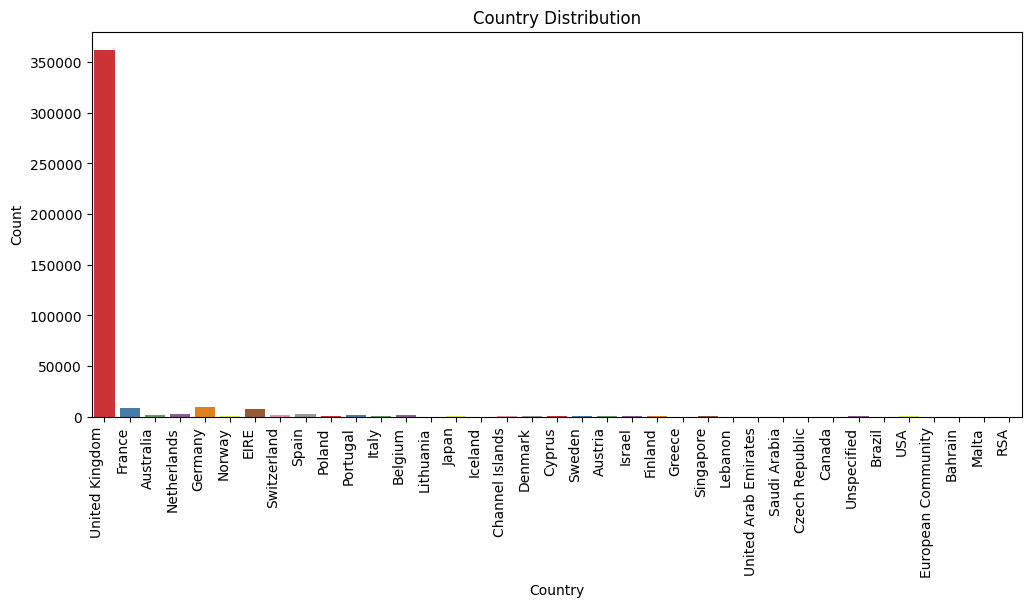

In [10]:
plt.figure(figsize=(12,5))
sns.countplot(x=df['Country'], palette='Set1')
plt.xticks(rotation=90,ha='right')
plt.title("Country Distribution")
plt.xlabel('Country')
plt.ylabel('Count');


#### Year Distribution

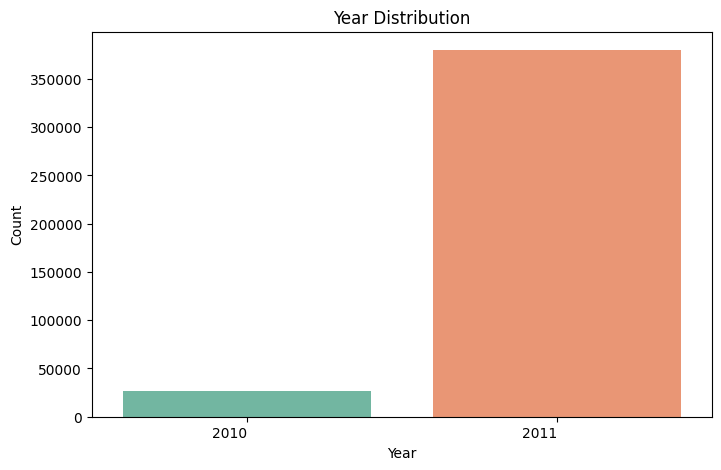

In [11]:
plt.figure(figsize=(8,5))
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
sns.countplot(x=df['InvoiceDate'].dt.year,palette= 'Set2')
plt.xticks(rotation=0,ha='right')
plt.title("Year Distribution")
plt.xlabel('Year')
plt.ylabel('Count');

#### Month Distribution

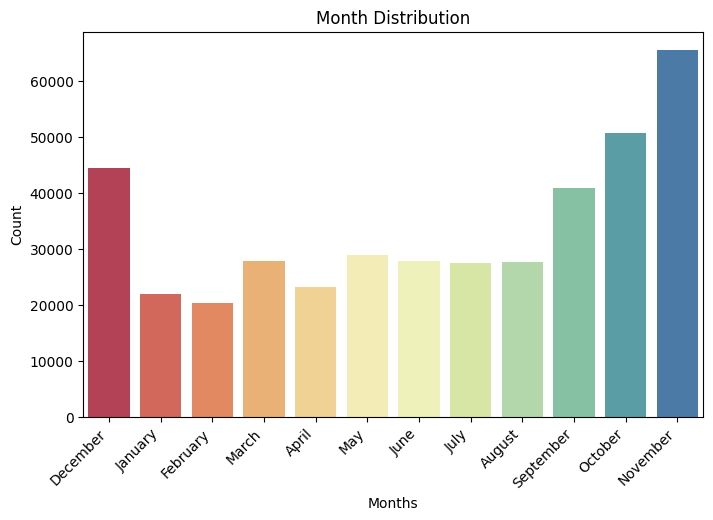

In [12]:
plt.figure(figsize=(8,5))
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
sns.countplot(x=df['InvoiceDate'].dt.month_name(),palette= 'Spectral')
plt.xticks(rotation=45,ha='right')
plt.title("Month Distribution")
plt.xlabel('Months')
plt.ylabel('Count');

#### Week Distribution

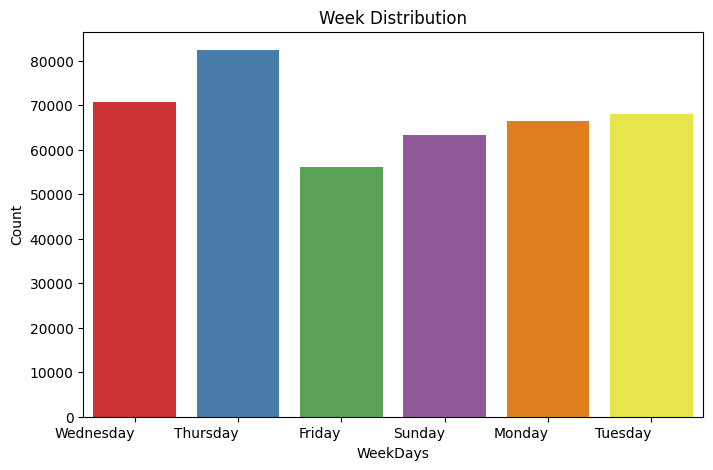

In [13]:
plt.figure(figsize=(8,5))
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
sns.countplot(x=df['InvoiceDate'].dt.day_name(),palette= 'Set1')
plt.xticks(rotation=0,ha='right')
plt.title("Week Distribution")
plt.xlabel('WeekDays')
plt.ylabel('Count');

## Recency, Frequency and Monetary Fields Calculation

In [14]:
df['Monetary'] = df['Quantity']*df['UnitPrice']
df_m = df.groupby('CustomerID')['Monetary'].sum()
df_m = df_m.reset_index()
df_m = df_m[~(df_m['Monetary']<=0)]
df_m.head()

,CustomerID,Monetary
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40
5,12352.0,1545.41


In [15]:
df_f = df.groupby('CustomerID')['InvoiceNo'].count()
df_f = df_f.reset_index()
df_f.columns = ['CustomerID', 'Frequency']
df_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [16]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M')
max_date = max(df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [17]:
df['diff_days'] = max_date+datetime.timedelta(days=1) - df['InvoiceDate']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Monetary,diff_days
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,374 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,374 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,374 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,374 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,374 days 04:24:00


In [18]:
df_r = df.groupby('CustomerID')['diff_days'].min()
df_r = df_r.reset_index()
df_r.head()

,CustomerID,diff_days
0,12346.0,326 days 02:33:00
1,12347.0,2 days 20:58:00
2,12348.0,75 days 23:37:00
3,12349.0,19 days 02:59:00
4,12350.0,310 days 20:49:00


In [19]:
df_r['Recency'] = df_r['diff_days'].dt.days
df_r.drop('diff_days', axis=1, inplace=True)
df_r.head()

,CustomerID,Recency
0,12346.0,326
1,12347.0,2
2,12348.0,75
3,12349.0,19
4,12350.0,310


## RFM Dataframe Creation

In [20]:
df_rfm = pd.merge(df_r, df_f, on="CustomerID", how='inner')
df_rfm = pd.merge(df_rfm, df_m, on="CustomerID", how="inner")

df_rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12347.0,2,182,4310.00
1,12348.0,75,31,1797.24
2,12349.0,19,73,1757.55
3,12350.0,310,17,334.40
4,12352.0,36,95,1545.41


### Outliers Handling

<AxesSubplot: >

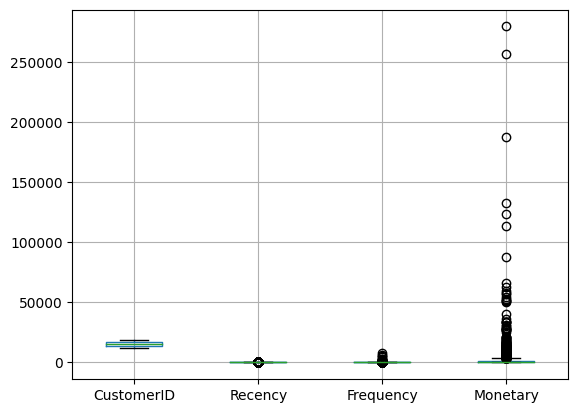

In [21]:
df_rfm.boxplot()

In [22]:
def outliers_removal(df, col):
    Q1 = df_rfm[col].quantile(0.25)
    Q3 = df_rfm[col].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[col] >= Q1 - 1.5*IQR) & (df[col] <= Q3 + 1.5*IQR)]
    return df

<AxesSubplot: >

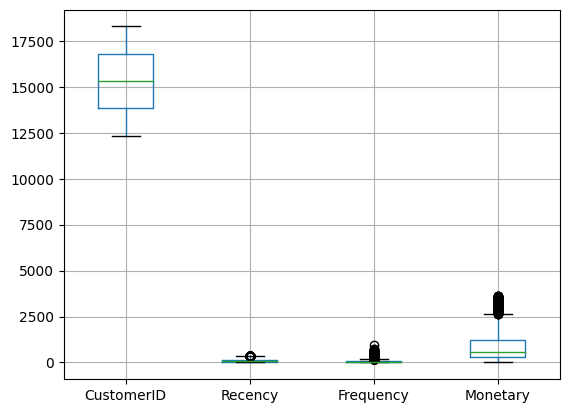

In [23]:
df_rfm = outliers_removal(df_rfm, 'Monetary')
df_rfm.boxplot()

<AxesSubplot: >

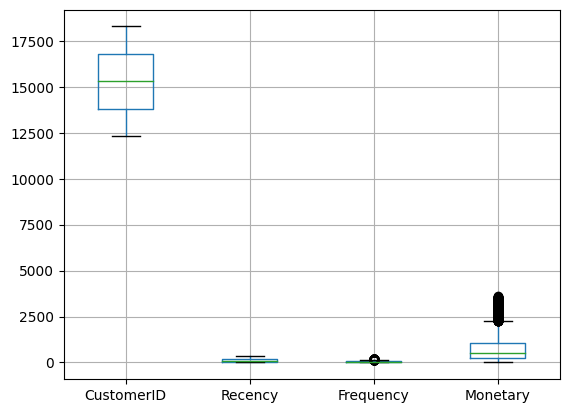

In [24]:
df_rfm = outliers_removal(df_rfm, 'Frequency')
df_rfm.boxplot()

<AxesSubplot: >

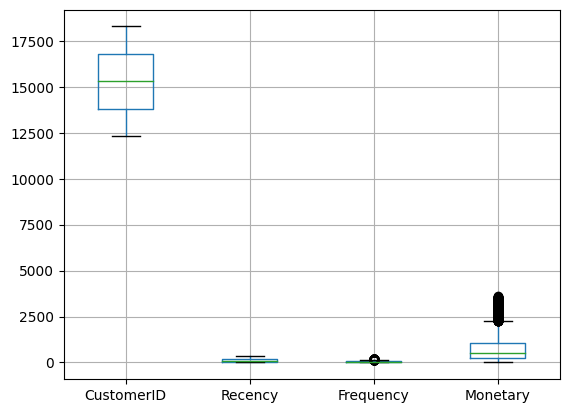

In [25]:
df_rfm = outliers_removal(df_rfm, 'Recency')
df_rfm.boxplot()

### Rescaling Different Attributes

In [26]:
df_rfm['Recency_log'] = df_rfm.Recency.apply(math.log)
df_rfm['Frequency_log'] = df_rfm.Frequency.apply(math.log)
df_rfm['Monetary_log'] = df_rfm.Monetary.apply(math.log)
df_rfm.head()
rfm_scaled = df_rfm[['Recency_log', 'Frequency_log', 'Monetary_log']]
rfm_scaled.columns = ['Recency', 'Frequency', 'Monetary']
rfm_scaled.head()

,Recency,Frequency,Monetary
1,4.317488,3.433987,7.494007
2,2.944439,4.290459,7.471676
3,5.736572,2.833213,5.812338
4,3.583519,4.553877,7.343045
5,5.318120,1.386294,4.488636


### k-Means with some of the arbitaries

In [27]:
km = KMeans(n_clusters=5, max_iter=50)
km.fit(rfm_scaled)

KMeans(max_iter=50, n_clusters=5)

In [28]:
km.labels_

array([2, 3, 0, ..., 0, 4, 2], dtype=int32)

## Elbow-curve Vs SSD

Text(0, 0.5, 'Intertia')

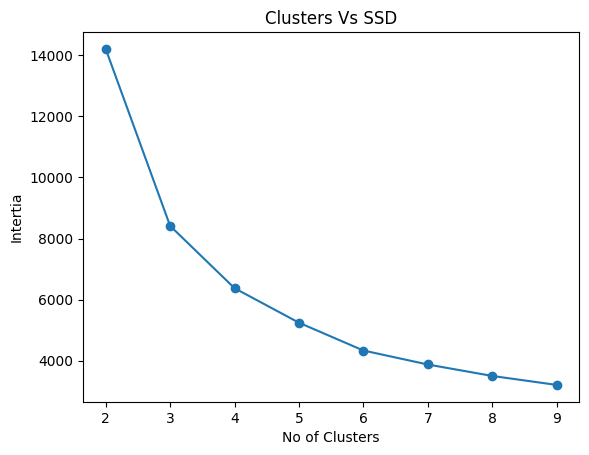

In [29]:
ssd = []
range_n_clusters = list(range(2,10))
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_scaled)
    
    ssd.append(kmeans.inertia_)
    

plt.plot(range_n_clusters,ssd, marker='o')
plt.title('Clusters Vs SSD')
plt.xlabel('No of Clusters')
plt.ylabel('Intertia')

In [30]:
for n in range_n_clusters:
    km = KMeans(n_clusters=n, max_iter=50)
    km.fit(rfm_scaled)
    labels = km.labels_
    silhouette_avg = silhouette_score(rfm_scaled, labels)
    print(f"For n_clusters={n}, Silhouette Score is {silhouette_avg}")

For n_clusters=2, Silhouette Score is 0.3622600148193357
For n_clusters=3, Silhouette Score is 0.3676177055849174
For n_clusters=4, Silhouette Score is 0.30391238071245547
For n_clusters=5, Silhouette Score is 0.3102333940076805
For n_clusters=6, Silhouette Score is 0.30265228734388055
For n_clusters=7, Silhouette Score is 0.2756389130688979
For n_clusters=8, Silhouette Score is 0.2762262451673922
For n_clusters=9, Silhouette Score is 0.2799097887255805


In [31]:
import timeit
st = timeit.default_timer()

def km_fit(df):
    km = KMeans(n_clusters=2, max_iter=50)
    km.fit(df)
    return km

km_times = []
for i in range(100):
    st = timeit.default_timer()
    km = km_fit(rfm_scaled)
    km_times.append(timeit.default_timer() - st)
    

km = km_fit(rfm_scaled)
km_time = np.mean(km_times)

km_time

0.0885625416203402

In [32]:
y = km.labels_

In [33]:
sum(y==0)

1858

In [34]:
df_rfm['label'] = km.labels_
df_rfm.head()

,CustomerID,Recency,Frequency,Monetary,Recency_log,Frequency_log,Monetary_log,label
1,12348.0,75,31,1797.24,4.317488,3.433987,7.494007,0
2,12349.0,19,73,1757.55,2.944439,4.290459,7.471676,0
3,12350.0,310,17,334.40,5.736572,2.833213,5.812338,1
4,12352.0,36,95,1545.41,3.583519,4.553877,7.343045,0
5,12353.0,204,4,89.00,5.318120,1.386294,4.488636,1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


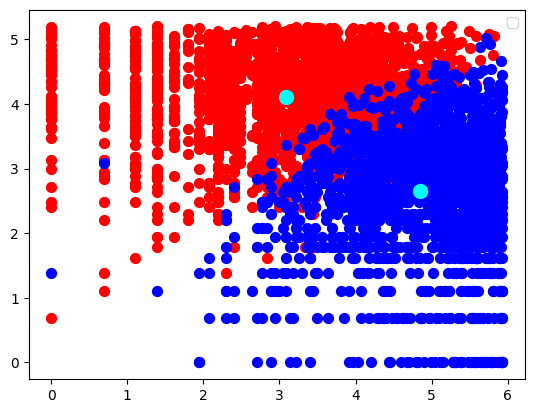

In [35]:
X=rfm_scaled.values
plt.scatter(X[y==0, 0], X[y==0, 1], s=50, c='red')
plt.scatter(X[y==1, 0], X[y==1, 1], s=50, c='blue')
# plt.scatter(X[y==2, 0], X[y==2, 1], s=50, c='green')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], s=100, color='cyan')
plt.legend()

In [36]:
km.cluster_centers_

array([[3.08646383, 4.10503781, 6.86979716],
       [4.84613825, 2.65080724, 5.50365195]])

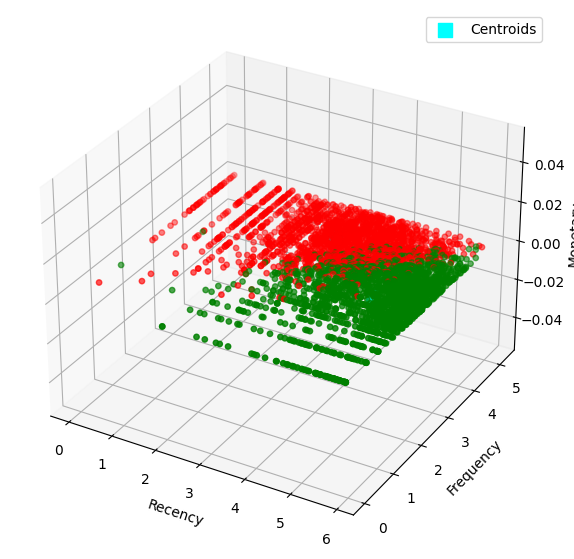

In [37]:
import matplotlib
fig=plt.figure(figsize=(9,7))
ax=fig.add_subplot(111,projection='3d')
xs=X[:,0]
ys=X[:,1]
# zs=X[:,2]
colors = ['red', 'blue', 'green']
ax.scatter(xs,ys,s=15,c=df_rfm['label'],cmap=matplotlib.colors.ListedColormap(colors))
ax.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], color = 'cyan', marker=',', 
            label = 'Centroids', s=100, alpha=1)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.legend()
plt.show()

In [38]:
silhouette_km = silhouette_score(rfm_scaled, y)
silhouette_km

0.362242450389406

## DBSCAN

In [39]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_rfm[['Recency_log', 'Monetary_log', 'Frequency_log']])
distances, indices = nbrs.kneighbors(df_rfm[['Recency_log', 'Monetary_log', 'Frequency_log']])


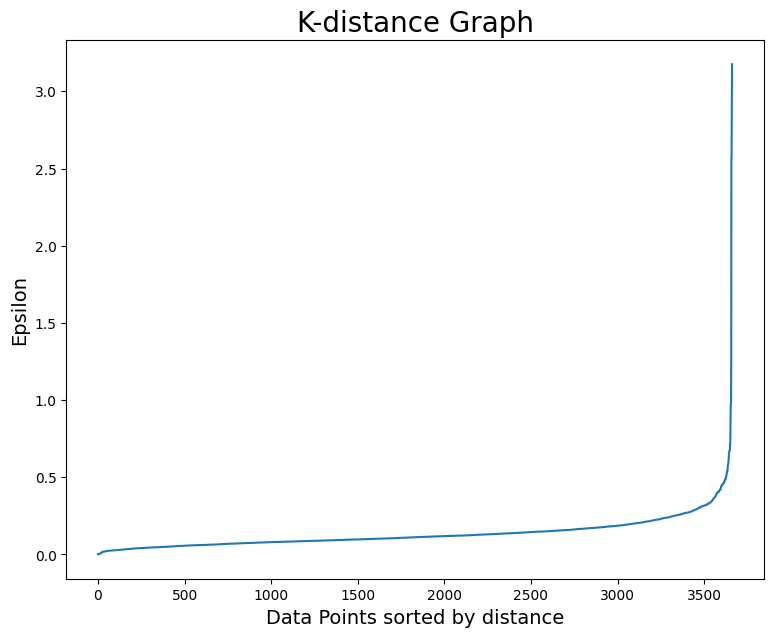

In [40]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances_new = distances[:,1]
plt.figure(figsize=(9, 7))
plt.plot(distances_new)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [41]:
from sklearn.cluster import DBSCAN

dbsc_times = []

for i in range(100):
    st = timeit.default_timer()
    dbscan_opt=DBSCAN(eps=0.5,min_samples=6)
    dbscan_opt.fit(df_rfm[['Recency_log', 'Monetary_log', 'Frequency_log']])
    dbsc_times.append(timeit.default_timer() - st)

db_time = np.mean(dbsc_times)
db_time

0.018650752099783858

In [42]:
df_rfm['DBSCAN_opt_labels']=dbscan_opt.labels_
df_rfm['DBSCAN_opt_labels'].value_counts()

 0    3481
-1     112
 1      38
 2      31
Name: DBSCAN_opt_labels, dtype: int64

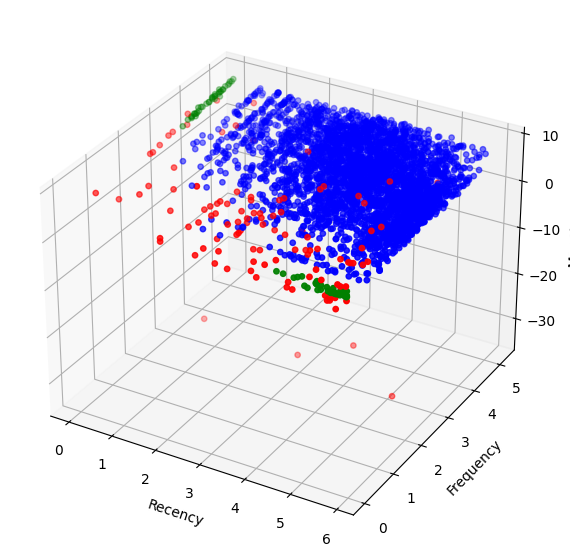

In [43]:
fig=plt.figure(figsize=(9,7))
ax=fig.add_subplot(111,projection='3d')
xs=df_rfm.Recency_log
ys=df_rfm.Frequency_log
zs=df_rfm.Monetary_log
# xs, ys, zs = X_scaled[:,0], X_scaled[:,1], X_scaled[:,2]
ax.scatter(xs,ys,zs,s=15,c=df_rfm['DBSCAN_opt_labels'],cmap=matplotlib.colors.ListedColormap(colors))
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.show()

In [44]:
from sklearn import metrics

silhouette_dbsc = metrics.silhouette_score(df_rfm[['Recency_log', 'Monetary_log', 'Frequency_log']], df_rfm['DBSCAN_opt_labels'])
silhouette_dbsc

0.22757369702848815

In [45]:
df_stats = pd.DataFrame(
    [
        ['Silhouette Score', silhouette_km, silhouette_dbsc],
        ['RunTime', km_time, db_time]
    ],
    columns=['Metrics', 'K Means', 'DBSCAN']
)

In [48]:
print(df_stats)

            Metrics   K Means    DBSCAN
0  Silhouette Score  0.362242  0.227574
1           RunTime  0.088563  0.018651


<AxesSubplot: xlabel='Metrics'>

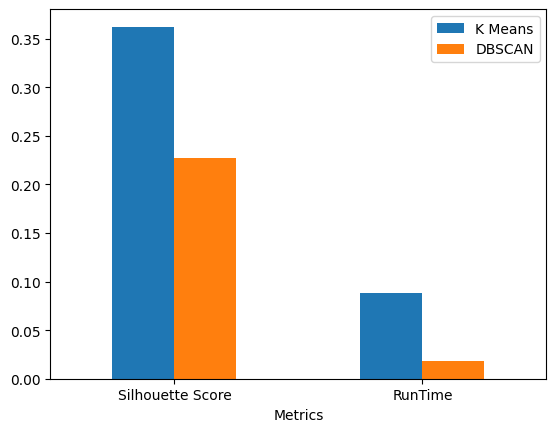

In [47]:
df_stats.plot.bar(x='Metrics', rot=0)